In [1]:
#%% LOAD PACKAGES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from datetime import datetime, timedelta
from scipy.optimize import least_squares
import calendar
import sklearn
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
work_dir=Path("/scratch/fransjevanoors/global_sr")

In [4]:
def regression_input(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th):
    # rename sr columns
    sr_df = sr_df.rename(columns={'2':'sr_2', '3':'sr_3', '5':'sr_5', '10':'sr_10', '20':'sr_20', '30':'sr_30', '40':'sr_40', '50':'sr_50', '60':'sr_60'})
    
    # concat catchment characteristics with sr dataframe
    df = pd.concat([cc_df,sr_df],axis=1)

    # define columns for regression (dpar and sr column)
    sr_rp = f'sr_{rp}'
    col = dpar.tolist() + [sr_rp]
    df = df[col]
    
    # treecover
    df_tc = cc_df[['tc', 'ntc', 'nonveg']]

    # select catchments based on treecover threshold
    df = df[df_tc['tc']>tc_th]
    df = df[df_tc['ntc']>ntc_th]
    df = df[df_tc['nonveg']>nonveg_th]

    # exclude nan catchments
    df = df.dropna()

    # exclude sr=zero catchments
    df = df[df[sr_rp]>0]

    # standardize values
    df_st = pd.DataFrame(index=df.index, columns=[col])
    df_st = (df - df.mean())/df.std()
    
    return df, df_st

In [5]:
def regression(df, df_st, dpar, rp):
    sr_rp = f'sr_{rp}' 
    x,sr = df_st[dpar],df_st[sr_rp]
    model = sm.OLS(sr,x)
    results = model.fit()
    par = np.round(results.params,3)
    pred_st = model.predict(par)
    r_sq = np.round(results.rsquared,3)
    r_sq_adj = np.round(results.rsquared_adj,3)
    aic = np.round(results.aic,3)
    pval = np.round(results.pvalues,3)
    nobs = results.nobs

    pred = pred_st * np.std(df[sr_rp]) + np.mean(df[sr_rp])
    x = df[sr_rp]
    y = pred
    
    return x,y,par,r_sq,r_sq_adj,aic,nobs

In [6]:
def regression_table(dpar,par,r_sq,r_sq_adj,aic,nobs, tc_th, ntc_th, nonveg_th):
    b = ['tc_th', 'ntc_th','nonveg_th', 'r_sq', 'r_sq_adj', 'aic', 'pval', 'nobs']
    col = np.concatenate([dpar,b])
    df = pd.DataFrame(index=[0],columns=col)
    df[dpar] = par
    df['tc_th']=tc_th
    df['ntc_th']=ntc_th
    df['nonveg_th']=nonveg_th
    df['r_sq'] = r_sq
    df['r_sq_adj'] = r_sq_adj
    df['aic'] = aic
    # df['pval'] = pval
    df['nobs'] = nobs
    return df


In [7]:
def regression_plot(sr,sr_pred,dpar,par,r_sq, tc_th, ntc_th, nonveg_th):    
    # Calculate the point density -> this only works if we have more points
    xy = np.vstack([sr,sr_pred])
    z = gaussian_kde(xy)(xy)
    x,y = sr, sr_pred
    
    #plot
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    # ax.plot(x,y,'mo',markersize=2)
    ax.scatter(x, y, c=z, s=1)
    ax.plot([0,1200],[0,1200],'r--')
    ax.set_xlabel('Sr water balance (mm)')
    ax.set_ylabel('Sr predicted (mm)')
    ax.set_xlim(0,800)
    ax.set_ylim(0,800)
    ax.text(0,-150,'Dpar: '+str(dpar))
    ax.text(0,-190,'Coeff: '+str(np.round(par.values,3)))
    ax.set_title(f'veg thresholds: tc:{tc_th}, ntc:{ntc_th}, nonveg:{nonveg_th},  R2={np.round(r_sq,3)}')
    

In [8]:
def run_regression(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th):
    # prepare input
    df = regression_input(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th)[0]
    df_st = regression_input(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th)[1]
    
    df_out = pd.DataFrame()
    
    if (len(df)>100):
        # regression
        rp = 20
        r = regression(df, df_st, dpar, rp)
        sr, sr_pred = r[0], r[1]
        par,r_sq,r_sq_adj,aic,nobs = r[2],r[3],r[4],r[5],r[6]

        # plot results
        # regression_plot(sr,sr_pred,dpar,par,r_sq, tc_th, ntc_th, nonveg_th)

        # make table
        if r_sq_adj>0.4:
            df_out = regression_table(dpar,par,r_sq,r_sq_adj,aic,nobs, tc_th, ntc_th, nonveg_th)

    return df_out

In [9]:
# read the catchment characteristics and sr tables
data_sources = 'gswp-p_gleam-ep_gswp-t'
cc_df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_{data_sources}.csv',index_col=0)
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)

# define the descriptor variables
dpar = ['si_ep','phi','si_p','slp_mean','dp','p_mean','idu_mean','si_ep','el_mean','tpi','cla','sp','st','se','sd']

# return period of Sr estimate
rp = 20

In [10]:
# define the vegetation thresholds for the regression
tc_th_ar = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
ntc_th_ar = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
nonveg_th_ar = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

tc_th_l = tc_th_ar * len(ntc_th_ar) * len(nonveg_th_ar)
tc_th_l.sort()
ntc_th_l = ntc_th_ar * len(tc_th_l)
nonveg_th_l = nonveg_th_ar * len(tc_th_ar)
nonveg_th_l.sort()
nonveg_th_l = nonveg_th_l*int(len(tc_th_l)/2)

li = []

for i in range(len(tc_th_l)):
    tc_th, ntc_th, nonveg_th = tc_th_l[i],ntc_th_l[i],nonveg_th_l[i]
    # print(tc_th,ntc_th,nonveg_th)
    df = run_regression(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th)
    li.append(df)

AttributeError: 'list' object has no attribute 'tolist'

In [ ]:
frame = pd.concat(li, axis=0) #concatenate dataframes in li
frame.index = np.arange(0,len(frame),1)

In [ ]:
s = frame.sort_values(by=['r_sq_adj'],ascending=False)
s[0:15]

NameError: name 's' is not defined

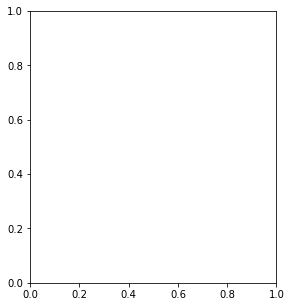

In [11]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.plot(s.tc_th, s.r_sq_adj,'mo',markersize=3)
ax.set_xlim(-0.05,0.8)
ax.set_ylim(0,1)
ax.set_xlabel('tree cover threshold')
ax.set_ylabel('r squared adjusted')

ax = fig.add_subplot(132)
ax.plot(s.ntc_th, s.r_sq_adj,'mo',markersize=3)
ax.set_xlim(-0.05,0.8)
ax.set_ylim(0,1)
ax.set_xlabel('non tree cover threshold')
ax.set_ylabel('r squared adjusted')

ax = fig.add_subplot(133)
ax.plot(s.nonveg_th, s.r_sq_adj,'mo',markersize=3)
ax.set_xlim(-0.05,0.8)
ax.set_ylim(0,1)
ax.set_xlabel('nonveg threshold')
ax.set_ylabel('r squared adjusted')

NameError: name 's' is not defined

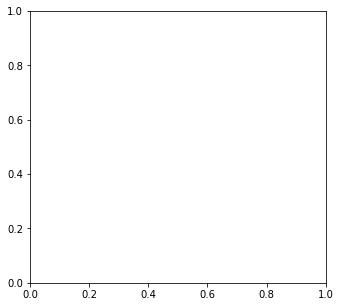

In [12]:
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(131)
ax.plot(s.tc_th, s.aic,'mo',markersize=3)
ax.set_xlim(-0.05,0.8)
# ax.set_ylim(0,1)
ax.set_xlabel('tree cover threshold')
ax.set_ylabel('aic')

ax = fig.add_subplot(132)
ax.plot(s.ntc_th, s.aic,'mo',markersize=3)
ax.set_xlim(-0.05,0.8)
# ax.set_ylim(0,1)
ax.set_xlabel('non tree cover threshold')
ax.set_ylabel('aic')

ax = fig.add_subplot(133)
ax.plot(s.nonveg_th, s.aic,'mo',markersize=3)
ax.set_xlim(-0.05,0.8)
# ax.set_ylim(0,1)
ax.set_xlabel('nonveg threshold')
ax.set_ylabel('aic')


In [ ]:
plt.plot(s.tc_th, s.p_mean,'mo')

In [13]:
# read the catchment characteristics and sr tables
data_sources = 'gswp-p_gleam-ep_gswp-t'
cc_df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/catchment_characteristics_{data_sources}.csv',index_col=0)
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)

# define the descriptor variables
dpar_all = ['phi','si_p','slp_mean','dp','p_mean','idu_mean','si_ep','el_mean','tpi','cla','sp','st','se','sd']

# return period of Sr estimate
rp = 20

its = 15

# define the vegetation thresholds for the regression
tc_th_ar = [0,0.2,0.4,0.7]
ntc_th_ar = [0,0.2,0.4,0.7]
nonveg_th_ar = [0,0.2,0.4,0.7]

tc_th_l = tc_th_ar * len(ntc_th_ar) * len(nonveg_th_ar)
tc_th_l.sort()
ntc_th_l = ntc_th_ar * len(tc_th_l)
nonveg_th_l = nonveg_th_ar * len(tc_th_ar)
nonveg_th_l.sort()
nonveg_th_l = nonveg_th_l*int(len(tc_th_l)/2)

res = []
for i in range(its):
    li = []
    # Generate a random number of features
    N_columns =  list(np.random.choice(range(len(dpar_all)),1)+1)
    # print(N_columns)
    
    # Given the number of features, generate features without replacement
    columns = list(np.random.choice(range(len(dpar_all)), N_columns, replace=False))
    # print(columns)
    
    dpar_sel = np.array(dpar_all)[columns]
    # print(dpar_sel)
    
    for j in range(len(tc_th_l)):
        tc_th, ntc_th, nonveg_th = tc_th_l[j],ntc_th_l[j],nonveg_th_l[j]
        # print(tc_th,ntc_th,nonveg_th)
        df = run_regression(cc_df, sr_df, dpar_sel, rp, tc_th, ntc_th, nonveg_th)
        # if (df.empty==False):
        li.append(df)
    if (len(li)>0):
        frame = pd.concat(li, axis=0) #concatenate dataframes in li
        frame.index = np.arange(0,len(frame),1)
        cols = np.concatenate([dpar_all,['tc_th', 'ntc_th','nonveg_th', 'r_sq', 'r_sq_adj', 'aic', 'pval', 'nobs']])
        res2 = pd.DataFrame(index=[], columns=cols)
        res2[frame.columns] = frame
        res.append(res2)

In [14]:
df_f = pd.concat(res, axis=0)
df_f.index = np.arange(0,len(df_f),1)
df_f

,phi,si_p,slp_mean,dp,p_mean,idu_mean,si_ep,el_mean,tpi,cla,...,se,sd,tc_th,ntc_th,nonveg_th,r_sq,r_sq_adj,aic,pval,nobs
0,0.248,0.636,NaN,NaN,NaN,NaN,NaN,-0.208,0.106,NaN,...,0.018,NaN,0.0,0.0,0.0,0.432,0.431,11164.638,NaN,4906.0
1,0.249,0.639,NaN,NaN,NaN,NaN,NaN,-0.208,0.104,NaN,...,0.015,NaN,0.0,0.2,0.0,0.434,0.433,11103.875,NaN,4888.0
2,0.244,0.653,NaN,NaN,NaN,NaN,NaN,-0.216,0.101,NaN,...,0.044,NaN,0.0,0.4,0.0,0.432,0.431,9617.442,NaN,4228.0
3,0.241,0.695,NaN,NaN,NaN,NaN,NaN,-0.211,0.045,NaN,...,-0.030,NaN,0.0,0.7,0.0,0.531,0.526,1605.281,NaN,765.0
4,0.237,0.276,NaN,NaN,NaN,NaN,NaN,-0.275,0.167,NaN,...,0.028,NaN,0.2,0.4,0.2,0.428,0.408,491.670,NaN,210.0
5,NaN,NaN,NaN,0.016,-0.023,0.439,-0.481,-0.174,NaN,-0.037,...,-0.102,0.040,0.0,0.7,0.0,0.512,0.507,1717.299,NaN,802.0
6,0.153,NaN,-0.588,NaN,0.299,NaN,NaN,0.146,NaN,-0.029,...,-0.010,NaN,0.2,0.4,0.2,0.423,0.404,500.151,NaN,213.0
7,0.151,NaN,-0.153,NaN,NaN,0.380,-0.337,-0.105,0.055,NaN,...,0.025,NaN,0.0,0.2,0.0,0.403,0.402,11366.568,NaN,4888.0
8,0.200,NaN,-0.067,NaN,NaN,0.452,-0.408,-0.071,0.011,NaN,...,-0.087,NaN,0.0,0.7,0.0,0.537,0.533,1596.174,NaN,765.0
9,0.253,NaN,-0.239,NaN,NaN,0.194,-0.108,-0.090,0.094,NaN,...,0.016,NaN,0.2,0.4,0.2,0.427,0.404,494.098,NaN,210.0


In [15]:
s = df_f.sort_values(by=['r_sq_adj'],ascending=False)
s[0:15]

,phi,si_p,slp_mean,dp,p_mean,idu_mean,si_ep,el_mean,tpi,cla,...,se,sd,tc_th,ntc_th,nonveg_th,r_sq,r_sq_adj,aic,pval,nobs
14,0.233,0.408,-0.060,0.028,0.088,0.194,-0.223,-0.134,0.033,-0.010,...,-0.085,NaN,0.0,0.7,0.0,0.579,0.571,1534.614,NaN,765.0
22,0.277,0.549,NaN,NaN,0.125,0.163,NaN,-0.183,NaN,0.043,...,-0.059,NaN,0.0,0.7,0.0,0.557,0.553,1637.333,NaN,802.0
8,0.200,NaN,-0.067,NaN,NaN,0.452,-0.408,-0.071,0.011,NaN,...,-0.087,NaN,0.0,0.7,0.0,0.537,0.533,1596.174,NaN,765.0
29,NaN,0.524,0.015,0.026,0.048,NaN,-0.340,-0.247,0.062,-0.070,...,-0.105,0.046,0.0,0.7,0.0,0.534,0.527,1607.807,NaN,765.0
3,0.241,0.695,NaN,NaN,NaN,NaN,NaN,-0.211,0.045,NaN,...,-0.030,NaN,0.0,0.7,0.0,0.531,0.526,1605.281,NaN,765.0
5,NaN,NaN,NaN,0.016,-0.023,0.439,-0.481,-0.174,NaN,-0.037,...,-0.102,0.040,0.0,0.7,0.0,0.512,0.507,1717.299,NaN,802.0
18,0.216,0.065,-0.472,-0.085,0.350,0.283,-0.103,0.181,0.265,-0.234,...,-0.008,NaN,0.2,0.4,0.2,0.512,0.480,466.035,NaN,208.0
10,NaN,0.597,NaN,NaN,NaN,0.147,NaN,-0.270,NaN,NaN,...,0.026,NaN,0.0,0.7,0.0,0.482,0.478,1760.384,NaN,803.0
12,0.231,0.450,-0.140,0.008,-0.080,0.105,-0.162,-0.178,-0.006,0.131,...,0.012,NaN,0.0,0.2,0.0,0.474,0.473,10731.940,NaN,4879.0
13,0.234,0.467,-0.158,0.007,-0.082,0.109,-0.142,-0.177,-0.010,0.123,...,0.036,NaN,0.0,0.4,0.0,0.470,0.469,9322.511,NaN,4222.0
